In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ritz4566","key":"f706ec5201697b30f5c680eaeb38e4fe"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [03:55<00:00, 24.8MB/s]
100% 5.20G/5.20G [03:55<00:00, 23.7MB/s]


In [5]:
! mkdir SkinCancer

In [6]:
! unzip skin-cancer-mnist-ham10000.zip -d SkinCancer

Streaming output truncated to the last 5000 lines.
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: SkinCancer/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: SkinCancer/h

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
import seaborn as sns

In [8]:
metadata = pd.read_csv('/content/SkinCancer/HAM10000_metadata.csv')
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [9]:
class_codes = {dx:code for code, dx in enumerate(metadata['dx'].unique())}
class_codes

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}

In [10]:
class_names = {code:dx for code, dx in enumerate(metadata['dx'].unique())}
class_names

{0: 'bkl', 1: 'nv', 2: 'df', 3: 'mel', 4: 'vasc', 5: 'bcc', 6: 'akiec'}

In [11]:
BATCH_SIZE = 5

def get_coded_labels(directory, metadata, class_code):
  dict_ = {'image_id' : [x[:-4] for x in os.listdir(directory)]}
  coded_labels = pd.DataFrame(dict_).sort_values('image_id').merge(metadata, on='image_id', how='inner')['dx'].map(lambda x: class_code[x])
  return list(coded_labels)

dataset_part1 = keras.utils.image_dataset_from_directory(
    directory='/content/SkinCancer/HAM10000_images_part_1',
    labels=get_coded_labels('/content/SkinCancer/HAM10000_images_part_1', metadata, class_codes),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
)

dataset_part2 = keras.utils.image_dataset_from_directory(
    directory='/content/SkinCancer/HAM10000_images_part_2',
    labels=get_coded_labels('/content/SkinCancer/HAM10000_images_part_2', metadata, class_codes),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
)

train_ds, test_ds = keras.utils.split_dataset(dataset = dataset_part1.concatenate(dataset_part2), left_size=0.8, shuffle=True)


Found 5000 files belonging to 7 classes.
Found 5015 files belonging to 7 classes.


In [12]:
tf.data.DatasetSpec.from_value(train_ds)

DatasetSpec((TensorSpec(shape=(5, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5, 7), dtype=tf.float32, name=None)), TensorShape([]))

In [13]:
card = train_ds.cardinality().numpy()*BATCH_SIZE

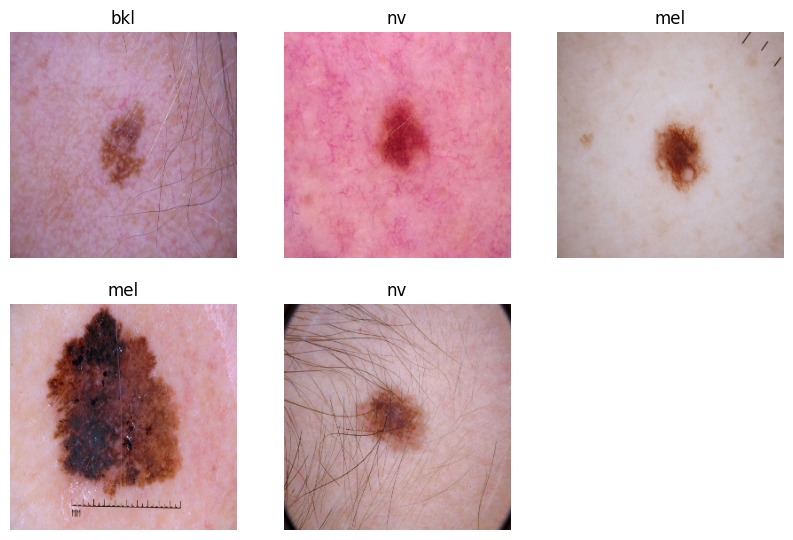

In [14]:
plt.figure(figsize=(10, 10))
for image, labels in train_ds.take(1):
  im_shape = tf.shape(image[0])
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

<ipython-input-15-7d6faa8fd1fb>:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_label_df = pd.concat([


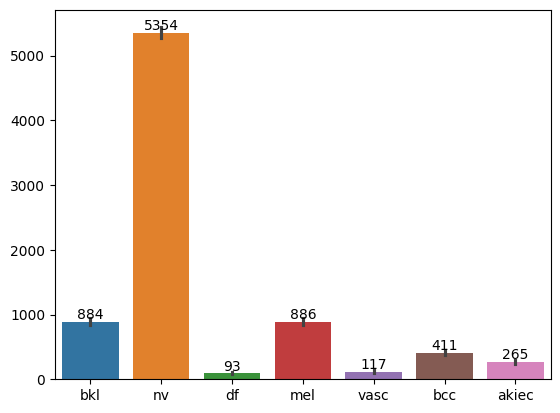

In [15]:
train_label_df = pd.DataFrame(columns = class_codes.keys())
for images, labels in train_ds.as_numpy_iterator():
    train_label_df = pd.concat([
        train_label_df,
        pd.DataFrame(columns=class_codes.keys(), data= labels)
    ])

ax = sns.barplot(train_label_df*card)
for i in ax.containers:
    ax.bar_label(i,)

In [16]:
train_label_df.sum()

bkl       884.0
nv       5354.0
df         93.0
mel       886.0
vasc      117.0
bcc       411.0
akiec     265.0
dtype: float32

In [17]:
data_agumentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

def data_agumenatation(images):
  for layer in data_agumentation_layers:
    images = layer(images)
  return images

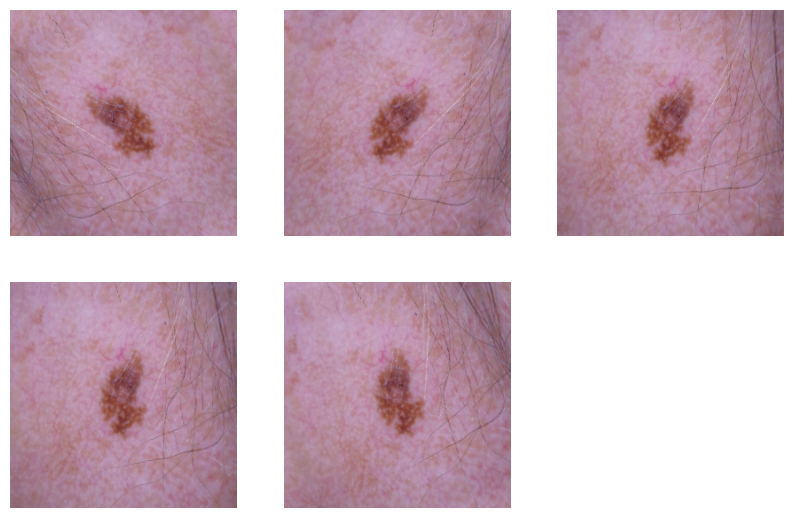

In [18]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(5):
    agumented_images = data_agumenatation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(agumented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
from keras.applications import InceptionV3
from keras import layers
inputs = keras.Input(shape = tuple(im_shape.numpy()))
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False
x = data_agumenatation(inputs)
x = layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(class_codes.keys()), activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │          14,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,817,127 (83.23 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [20]:
model.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.CategoricalCrossentropy(), metrics = [keras.metrics.Precision(), keras.metrics.Recall()])
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

print("Fitting the top layer of the model")
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Fitting the top layer of the model
Epoch 1/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 61s 29ms/step - loss: 0.9745 - precision: 0.7646 - recall: 0.6171 - val_loss: 0.8443 - val_precision: 0.7912 - val_recall: 0.6085
Epoch 2/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - loss: 0.7313 - precision: 0.8049 - recall: 0.6906 - val_loss: 0.8225 - val_precision: 0.7764 - val_recall: 0.6459
Epoch 3/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - loss: 0.6648 - precision: 0.8219 - recall: 0.7140 - val_loss: 0.8238 - val_precision: 0.7687 - val_recall: 0.6549
Epoch 4/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - loss: 0.6182 - precision: 0.8306 - recall: 0.7310 - val_loss: 0.8345 - val_precision: 0.7645 - val_recall: 0.6574
Epoch 5/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - loss: 0.5824 - precision: 0.8389 - recall: 0.7452 - val_loss: 0.8485 - val_precision: 0.7557 - val_recall: 0.6618


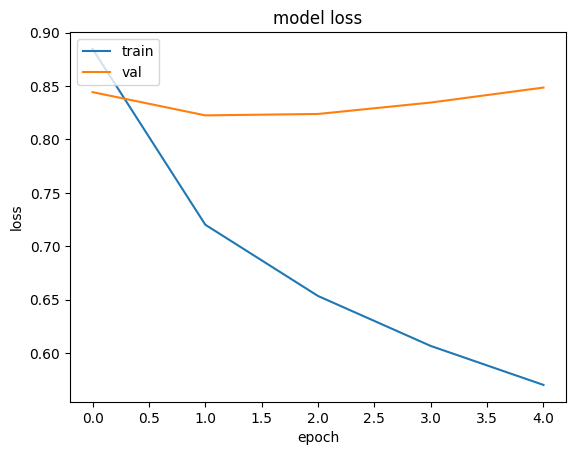

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics = [keras.metrics.Precision(), keras.metrics.Recall()])
epochs = 1
print("Fitting the end-to-end model")
history2 = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 256, 256, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ inception_v3 (Functional)           │ (None, 6, 6, 2048)           │    21,802,784 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 7)                    │        14,343 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 21,845,815 (83.34 MB)

 Trainable params: 21,782,695 (83.09 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 28,688 (112.07 KB)

Fitting the end-to-end model
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 194s 79ms/step - loss: 0.9575 - precision_1: 0.7553 - recall_1: 0.6128 - val_loss: 0.7823 - val_precision_1: 0.8077 - val_recall_1: 0.6768


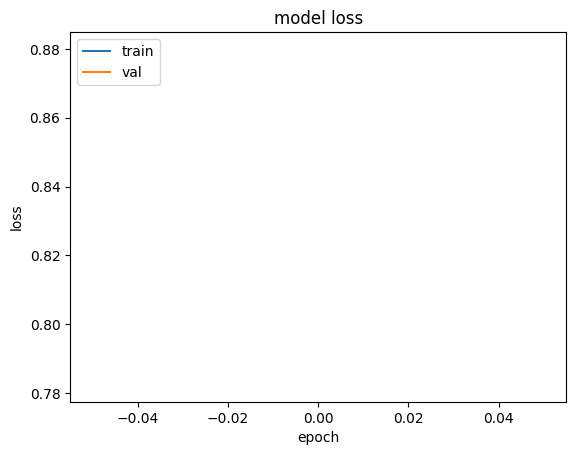

In [23]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


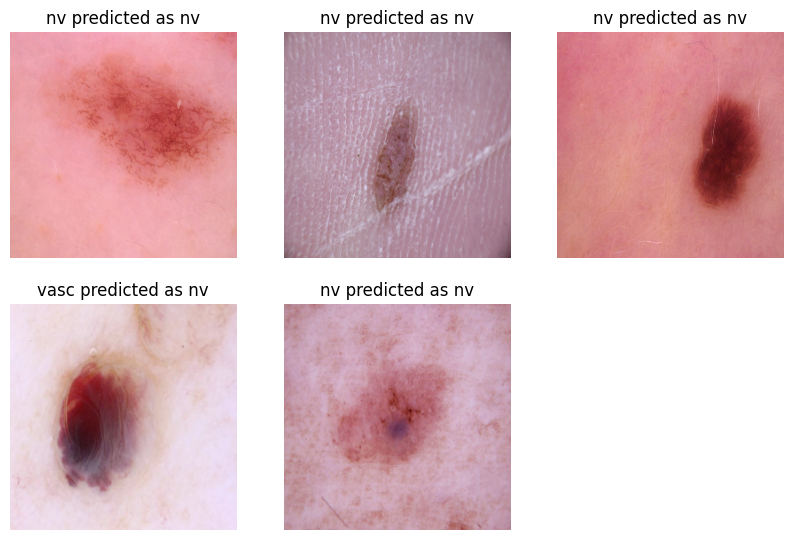

In [24]:
plt.figure(figsize=(10, 10))
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(f"{labels[i]} predicted as {np.argmax(predictions[i])}")
        plt.title(f"{class_names.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0])} predicted as {class_names.get(np.argmax(predictions[i]))}")
        plt.axis("off")

In [25]:
from keras.applications import ResNet50
base_model = ResNet50(input_shape = (256, 256, 3), weights='imagenet', include_top=False)
base_model.trainable = False
x = data_agumenatation(inputs)
x = layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(class_codes.keys()), activation='softmax')(x)

model_1 = keras.Model(inputs, outputs)
model_1.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │          14,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
model_1.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.CategoricalCrossentropy(), metrics = [keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_resnet.keras"),
]

print("Fitting the top layer of the model")
history_resnet = model_1.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Fitting the top layer of the model
Epoch 1/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 54s 28ms/step - accuracy: 0.6595 - loss: 1.2042 - precision_2: 0.6704 - recall_2: 0.6206 - val_accuracy: 0.6728 - val_loss: 1.1324 - val_precision_2: 0.6861 - val_recall_2: 0.6648
Epoch 2/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.6674 - loss: 1.1534 - precision_2: 0.6820 - recall_2: 0.6354 - val_accuracy: 0.6728 - val_loss: 1.1133 - val_precision_2: 0.7106 - val_recall_2: 0.6504
Epoch 3/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.6686 - loss: 1.1320 - precision_2: 0.6933 - recall_2: 0.6333 - val_accuracy: 0.6748 - val_loss: 1.0995 - val_precision_2: 0.7285 - val_recall_2: 0.6289
Epoch 4/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.6694 - loss: 1.1160 - precision_2: 0.7014 - recall_2: 0.6291 - val_accuracy: 0.6798 - val_loss: 1.0888 - val_precision_2: 0.7368 - val_recall_2: 0.6145
Epoch 5/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.6718 - loss:

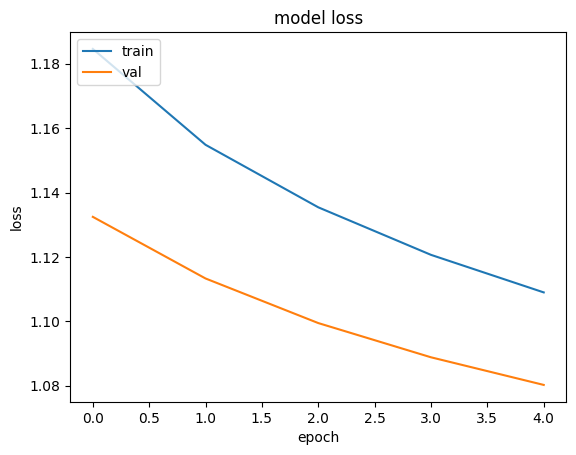

In [27]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


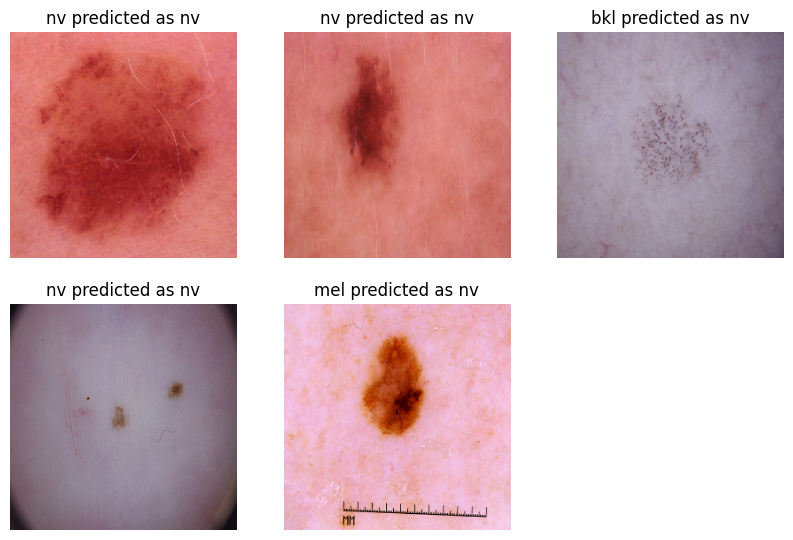

In [28]:
plt.figure(figsize=(10, 10))
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())
for images, labels in test_ds.take(1):
    predictions = model_1.predict(images)
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(f"{labels[i]} predicted as {np.argmax(predictions[i])}")
        plt.title(f"{class_names.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0])} predicted as {class_names.get(np.argmax(predictions[i]))}")
        plt.axis("off")

In [29]:
from tensorflow.keras.applications import MobileNetV3Large

base_model = MobileNetV3Large(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False
x = data_agumenatation(inputs)
x = layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_codes.keys()), activation='softmax')(x)

model_2 = keras.Model(inputs, outputs)
model_2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 8, 8, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         123,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,128,071 (11.93 MB)

 Trainable params: 131,719 (514.53 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [30]:
model_2.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.CategoricalCrossentropy(), metrics = [keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_mobilenet.keras")]

print("Filling in Model")
history_mobilenet = model_2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Filling in Model
Epoch 1/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.6616 - loss: 1.1667 - precision_3: 0.6667 - recall_3: 0.6480 - val_accuracy: 0.6738 - val_loss: 1.1152 - val_precision_3: 0.6738 - val_recall_3: 0.6738
Epoch 2/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6681 - loss: 1.1406 - precision_3: 0.6685 - recall_3: 0.6659 - val_accuracy: 0.6738 - val_loss: 1.1105 - val_precision_3: 0.6747 - val_recall_3: 0.6723
Epoch 3/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6681 - loss: 1.1350 - precision_3: 0.6684 - recall_3: 0.6658 - val_accuracy: 0.6738 - val_loss: 1.1076 - val_precision_3: 0.6754 - val_recall_3: 0.6723
Epoch 4/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6681 - loss: 1.1325 - precision_3: 0.6687 - recall_3: 0.6647 - val_accuracy: 0.6738 - val_loss: 1.1051 - val_precision_3: 0.6757 - val_recall_3: 0.6713
Epoch 5/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6681 - loss: 1.1288 - precision_3:

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


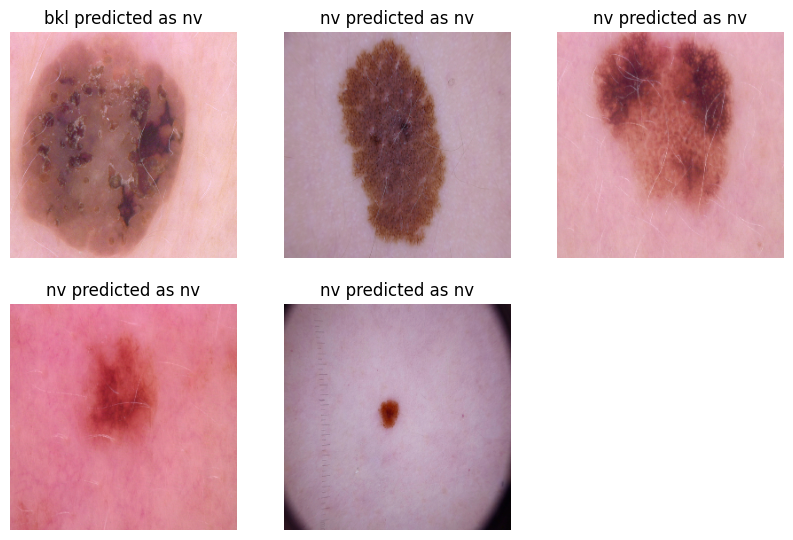

In [31]:
plt.figure(figsize=(10, 10))
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())
for images, labels in test_ds.take(1):
    predictions = model_2.predict(images)
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(f"{labels[i]} predicted as {np.argmax(predictions[i])}")
        plt.title(f"{class_names.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0])} predicted as {class_names.get(np.argmax(predictions[i]))}")
        plt.axis("off")

In [32]:
def attention_block(inputs):
  gap = layers.GlobalAveragePooling2D()(inputs)
  dense = layers.Dense(inputs.shape[-1], activation='softmax')(gap)
  dense_reshaped = layers.Reshape((1,1, inputs.shape[-1]))(dense)
  attention_output = layers.Multiply()([inputs, dense_reshaped])
  return attention_output

inputs = keras.Input(shape = tuple(im_shape.numpy()))
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False
x = data_agumenatation(inputs)
x = layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
attention_block = attention_block(x)
x = layers.GlobalAveragePooling2D()(attention_block)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_codes.keys()), activation='softmax')(x)

model_3 = keras.Model(inputs, outputs)
model_3.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 6, 6, 2048)     │     21,802,784 │ rescaling_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ inception_v3[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2048)           │      4,196,352 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 2048)     │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_8 (Multiply)     │ (None, 6, 6, 2048)     │              0 │ inception_v3[0][0],    │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ multiply_8[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 128)            │        262,272 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 64)             │          8,256 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 7)              │            455 │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,270,119 (100.21 MB)

 Trainable params: 4,467,335 (17.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [33]:
model_3.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.CategoricalCrossentropy(), metrics = [keras.metrics.Precision(), keras.metrics.Recall()])
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_attention.keras"),
]

print("Fitting the top layer of the model")
history = model_3.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Fitting the top layer of the model
Epoch 1/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 63s 30ms/step - loss: 1.0974 - precision_4: 0.7692 - recall_4: 0.5074 - val_loss: 0.9189 - val_precision_4: 0.8688 - val_recall_4: 0.5481
Epoch 2/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.9102 - precision_4: 0.8635 - recall_4: 0.5894 - val_loss: 0.8949 - val_precision_4: 0.8837 - val_recall_4: 0.5571
Epoch 3/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.8737 - precision_4: 0.8703 - recall_4: 0.5927 - val_loss: 0.8837 - val_precision_4: 0.8773 - val_recall_4: 0.5601
Epoch 4/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.8441 - precision_4: 0.8672 - recall_4: 0.6008 - val_loss: 0.8548 - val_precision_4: 0.8728 - val_recall_4: 0.5815
Epoch 5/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.8299 - precision_4: 0.8729 - recall_4: 0.6044 - val_loss: 0.8698 - val_precision_4: 0.8724 - val_recall_4: 0.5865


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


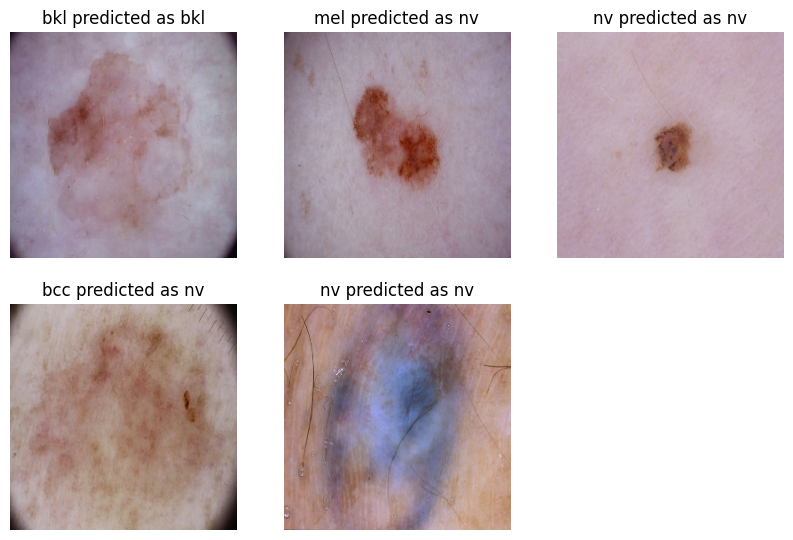

In [34]:
plt.figure(figsize=(10, 10))
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())
for images, labels in test_ds.take(1):
    predictions = model_3.predict(images)
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(f"{labels[i]} predicted as {np.argmax(predictions[i])}")
        plt.title(f"{class_names.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0])} predicted as {class_names.get(np.argmax(predictions[i]))}")
        plt.axis("off")

In [35]:
class SelfAttention(tf.keras.layers.Layer):
  def __init__(self, num_heads=8, key_dim=64):
    super(SelfAttention, self).__init__()
    self.num_heads = num_heads
    self.key_dim = key_dim
    self.query_layer = layers.Dense(self.key_dim * self.num_heads)
    self.key_layer = layers.Dense(self.key_dim * self.num_heads)
    self.value_layer = layers.Dense(self.key_dim * self.num_heads)
    self.softmax = layers.Softmax(axis=-1)
    self.layer_norm = layers.LayerNormalization()
    self.output_layer = layers.Dense(2048)

  def call(self, inputs):
    queries = self.query_layer(inputs)
    keys = self.key_layer(inputs)
    values = self.value_layer(inputs)

    attention_scores = tf.matmul(queries, keys, transpose_b=True)/tf.math.sqrt(tf.cast(self.key_dim, tf.float32))
    attention_weights = self.softmax(attention_scores)
    attention_output = tf.matmul(attention_weights, values)
    attention_output = self.output_layer(attention_output)
    output = self.layer_norm(inputs + attention_output)
    return output

inputs = keras.Input(shape = tuple(im_shape.numpy()))
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False
x = data_agumenatation(inputs)
x = layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
self_attention_block = SelfAttention(num_heads = 4, key_dim = 64)(x)
x = layers.GlobalAveragePooling2D()(self_attention_block)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_codes.keys()), activation='softmax')(x)

model_4 = keras.Model(inputs, outputs)
model_4.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ self_attention (SelfAttention)       │ (None, 6, 6, 2048)          │       2,104,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,177,831 (92.23 MB)

 Trainable params: 2,375,047 (9.06 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [36]:
model_4.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.CategoricalCrossentropy(), metrics = [keras.metrics.Precision(), keras.metrics.Recall()])
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_selfattention.keras"),
]

print("Fitting the top layer of the model")
history = model_4.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Fitting the top layer of the model
Epoch 1/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 61s 30ms/step - loss: 1.1160 - precision_5: 0.7656 - recall_5: 0.5650 - val_loss: 1.0009 - val_precision_5: 0.8457 - val_recall_5: 0.4594
Epoch 2/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.8940 - precision_5: 0.8391 - recall_5: 0.5830 - val_loss: 0.9147 - val_precision_5: 0.8099 - val_recall_5: 0.5377
Epoch 3/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.8425 - precision_5: 0.8467 - recall_5: 0.6004 - val_loss: 0.8991 - val_precision_5: 0.7989 - val_recall_5: 0.5606
Epoch 4/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.7912 - precision_5: 0.8479 - recall_5: 0.6125 - val_loss: 0.9286 - val_precision_5: 0.7907 - val_recall_5: 0.5521
Epoch 5/5
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.7523 - precision_5: 0.8532 - recall_5: 0.6307 - val_loss: 0.9780 - val_precision_5: 0.8391 - val_recall_5: 0.5307


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


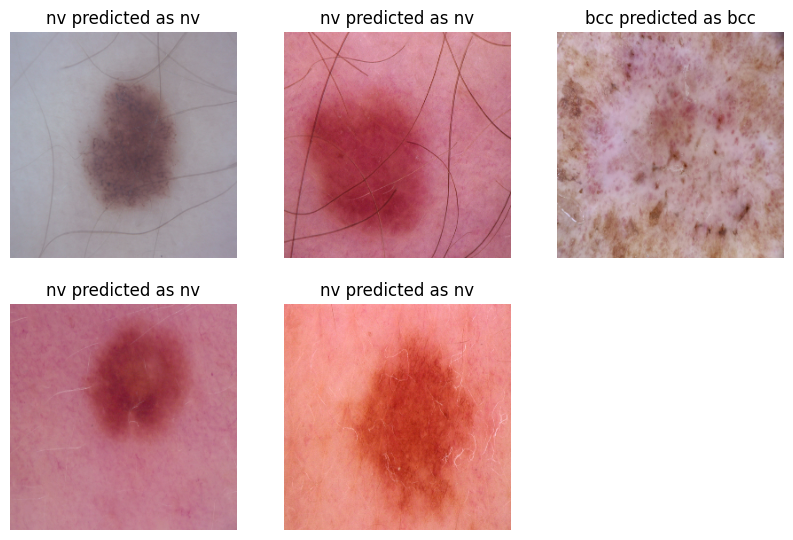

In [37]:
plt.figure(figsize=(10, 10))
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())
for images, labels in test_ds.take(1):
    predictions = model_4.predict(images)
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(f"{labels[i]} predicted as {np.argmax(predictions[i])}")
        plt.title(f"{class_names.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0])} predicted as {class_names.get(np.argmax(predictions[i]))}")
        plt.axis("off")

In [58]:
from tensorflow.keras.layers import Layer
class CBAM(Layer):
  def __init__(self, channels, reduction_ratio=16):
    super(CBAM, self).__init__()
    self.channels = channels
    self.reduction_ratio = reduction_ratio

  def build(self, input_shape):
    self.avg_pool = layers.GlobalAveragePooling2D()
    self.max_pool = layers.GlobalMaxPooling2D()
    self.fc1 = layers.Dense(self.channels // self.reduction_ratio, activation='relu')
    self.fc2 = layers.Dense(self.channels)
    self.conv = layers.Conv2D(filters=1, kernel_size=7, strides=1,activation='sigmoid', padding='same')

  def channel_attention(self, inputs):
    avg_pooled = self.avg_pool(inputs)
    max_pooled = self.max_pool(inputs)

    avg_pooled = self.fc1(avg_pooled)
    max_pooled = self.fc1(max_pooled)

    avg_pooled = self.fc2(avg_pooled)
    max_pooled = self.fc2(max_pooled)

    attention = tf.nn.sigmoid(avg_pooled + max_pooled)
    attention = tf.reshape(attention, [-1, 1, 1, self.channels])

    return inputs * attention

  def spatial_attention(self, inputs):
    avg_pooled = tf.reduce_mean(inputs, axis=-1, keepdims=True)
    max_pooled = tf.reduce_max(inputs, axis=-1, keepdims=True)

    concat = tf.concat([avg_pooled, max_pooled], axis=-1)
    conv = self.conv(concat)
    conv = tf.nn.sigmoid(conv)

    return inputs * conv

  def call(self, inputs):
    x = self.channel_attention(inputs)
    x = self.spatial_attention(x)

    return x

In [59]:
inputs = keras.Input(shape = tuple(im_shape.numpy()))
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False
x = data_agumenatation(inputs)
x = layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
cbam_attention_block = CBAM(channels=2048)(x)
x = layers.GlobalAveragePooling2D()(cbam_attention_block)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_codes.keys()), activation='softmax')(x)

model_5 = keras.Model(inputs, outputs)
model_5.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_15 (Rescaling)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam_7 (CBAM)                        │ (None, 6, 6, 2048)          │         526,563 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_17          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,600,330 (86.21 MB)

 Trainable params: 797,546 (3.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [60]:
model_5.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.CategoricalCrossentropy(), metrics = [keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.Accuracy()])
epochs = 15
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_cbamattention.keras"),
]

print("Fitting the top layer of the model")
history = model_5.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Fitting the top layer of the model
Epoch 1/15
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 62s 30ms/step - accuracy: 0.0000e+00 - loss: 0.9449 - precision_8: 0.8045 - recall_8: 0.5869 - val_accuracy: 0.0000e+00 - val_loss: 0.8691 - val_precision_8: 0.8212 - val_recall_8: 0.5382
Epoch 2/15
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.0000e+00 - loss: 0.7460 - precision_8: 0.8415 - recall_8: 0.6404 - val_accuracy: 0.0000e+00 - val_loss: 0.8101 - val_precision_8: 0.8240 - val_recall_8: 0.5815
Epoch 3/15
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.0000e+00 - loss: 0.6820 - precision_8: 0.8464 - recall_8: 0.6727 - val_accuracy: 0.0000e+00 - val_loss: 0.8207 - val_precision_8: 0.8095 - val_recall_8: 0.5955
Epoch 4/15
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.0000e+00 - loss: 0.6385 - precision_8: 0.8484 - recall_8: 0.6960 - val_accuracy: 0.0000e+00 - val_loss: 0.8233 - val_precision_8: 0.7853 - val_recall_8: 0.6095
Epoch 5/15
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


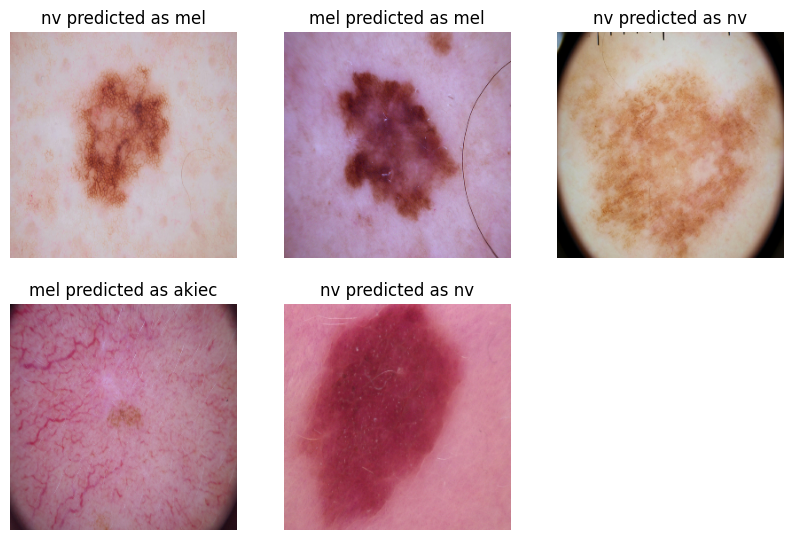

In [61]:
plt.figure(figsize=(10, 10))
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())
for images, labels in test_ds.take(1):
    predictions = model_5.predict(images)
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(f"{labels[i]} predicted as {np.argmax(predictions[i])}")
        plt.title(f"{class_names.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0])} predicted as {class_names.get(np.argmax(predictions[i]))}")
        plt.axis("off")

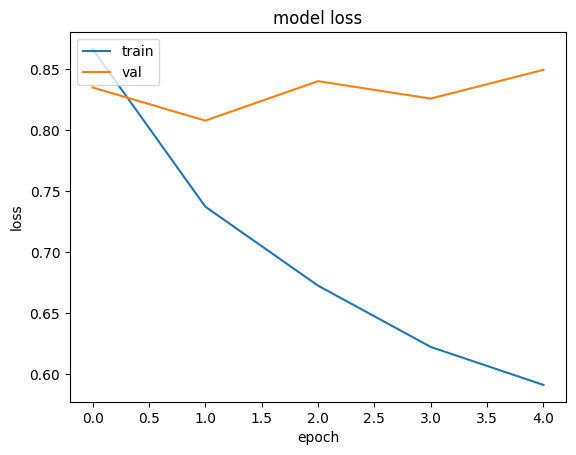

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
inputs = keras.Input(shape = tuple(im_shape.numpy()))
base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False
x = data_agumenatation(inputs)
x = layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
cbam_attention_block = CBAM(channels=2048)(x)
x = layers.GlobalAveragePooling2D()(cbam_attention_block)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_codes.keys()), activation='softmax')(x)

model_6 = keras.Model(inputs, outputs)
model_6.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_19 (Rescaling)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam_11 (CBAM)                       │ (None, 8, 8, 2048)          │         526,563 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_25          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,385,258 (93.02 MB)

 Trainable params: 797,546 (3.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [72]:
model_6.compile(optimizer = keras.optimizers.Adam(), loss = keras.losses.CategoricalCrossentropy(), metrics = [keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.Accuracy()])
epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_cbamattention_resnet.keras"),
]

print("Fitting the top layer of the model")
history = model_6.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Fitting the top layer of the model
Epoch 1/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.0000e+00 - loss: 1.1633 - precision_11: 0.6668 - recall_11: 0.6472 - val_accuracy: 0.0000e+00 - val_loss: 1.1154 - val_precision_11: 0.6738 - val_recall_11: 0.6738
Epoch 2/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.0000e+00 - loss: 1.1374 - precision_11: 0.6687 - recall_11: 0.6669 - val_accuracy: 0.0000e+00 - val_loss: 1.1050 - val_precision_11: 0.6745 - val_recall_11: 0.6718
Epoch 3/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.0000e+00 - loss: 1.1273 - precision_11: 0.6709 - recall_11: 0.6646 - val_accuracy: 0.0000e+00 - val_loss: 1.0923 - val_precision_11: 0.6880 - val_recall_11: 0.6653
Epoch 4/50
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.0000e+00 - loss: 1.1096 - precision_11: 0.6821 - recall_11: 0.6551 - val_accuracy: 0.0000e+00 - val_loss: 1.0738 - val_precision_11: 0.7386 - val_recall_11: 0.6075
Epoch 5/50
1602/1602 ━━━━━━━━

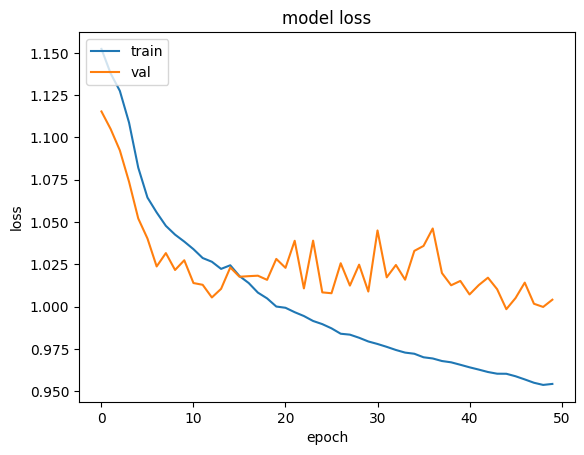

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


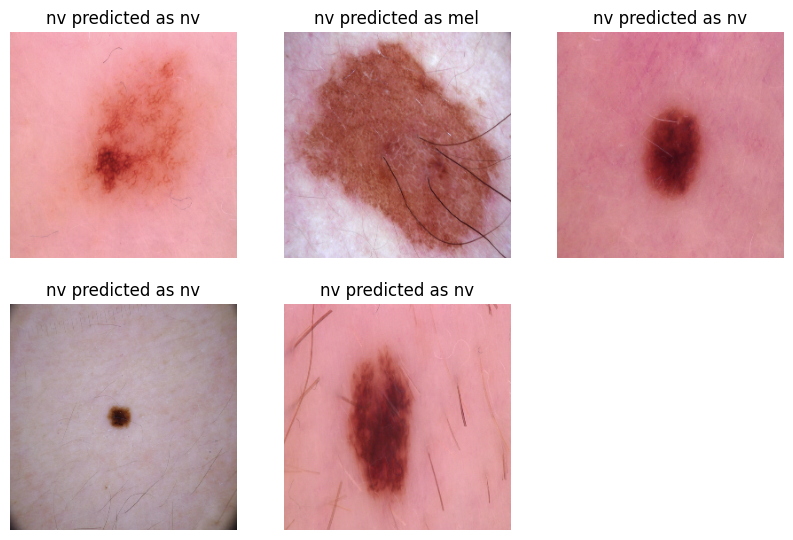

In [74]:
plt.figure(figsize=(10, 10))
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())
for images, labels in test_ds.take(1):
    predictions = model_6.predict(images)
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(f"{labels[i]} predicted as {np.argmax(predictions[i])}")
        plt.title(f"{class_names.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0])} predicted as {class_names.get(np.argmax(predictions[i]))}")
        plt.axis("off")

In [ ]:



from google.colab import files
files.download('/content/save_at_5_attention.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/save_at_5.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/save_at_5_cbamattention.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/save_at_5_resnet.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/save_at_5_selfattention.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>